In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("TCGA(1)/TCGA/dataset.csv")
outcome = pd.read_csv("TCGA(1)/TCGA/outcome.csv")


In [3]:
features = data.drop("Unnamed: 0", axis=1)
labels = outcome.drop("Unnamed: 0", axis=1)
labels = labels.dropna()

In [4]:
index = labels[labels['BRCA_subtype'].notna()].index

In [5]:
features = features.loc[index]

In [6]:
#scaler = StandardScaler()
#scaled_features = scaler.fit_transform(features)

In [7]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(labels)
n_clusters = len(label_encoder.classes_)

In [8]:
# You use MinMaxScaler when you do not assume that the shape of all your features follows a normal distribution. 
preprocessor = Pipeline([("scaler", MinMaxScaler()),("pca", PCA(n_components=2, random_state=42))])

In [24]:
clusterer = Pipeline([("kmeans", KMeans(n_clusters=n_clusters, init="k-means++", n_init = 50, max_iter=500, random_state=42))])

In [25]:
pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])


In [26]:
pipe.fit(features)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=20, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(init='random', max_iter=500,
                                         n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [27]:
preprocessed_data = pipe["preprocessor"].transform(features)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.15148380260891292

In [28]:
adjusted_rand_score(true_labels, predicted_labels)

0.34219768032531717

In [14]:
pcadf = pd.DataFrame(pipe["preprocessor"].transform(features),columns=["component_1", "component_2"],)
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)
pcadf

,component_1,component_2,predicted_cluster,true_label
0,-0.694122,-1.009623,0,Her2
1,0.675280,-1.053091,0,LumA
2,-6.224487,-0.984306,1,LumA
3,-8.448945,0.868992,1,LumB
4,0.429474,-3.470925,0,LumB
...,...,...,...,...
951,17.057391,1.339890,3,Normal
952,15.622186,2.401385,3,Normal
953,3.166757,-4.573013,0,LumA
954,16.536922,1.226728,3,Normal


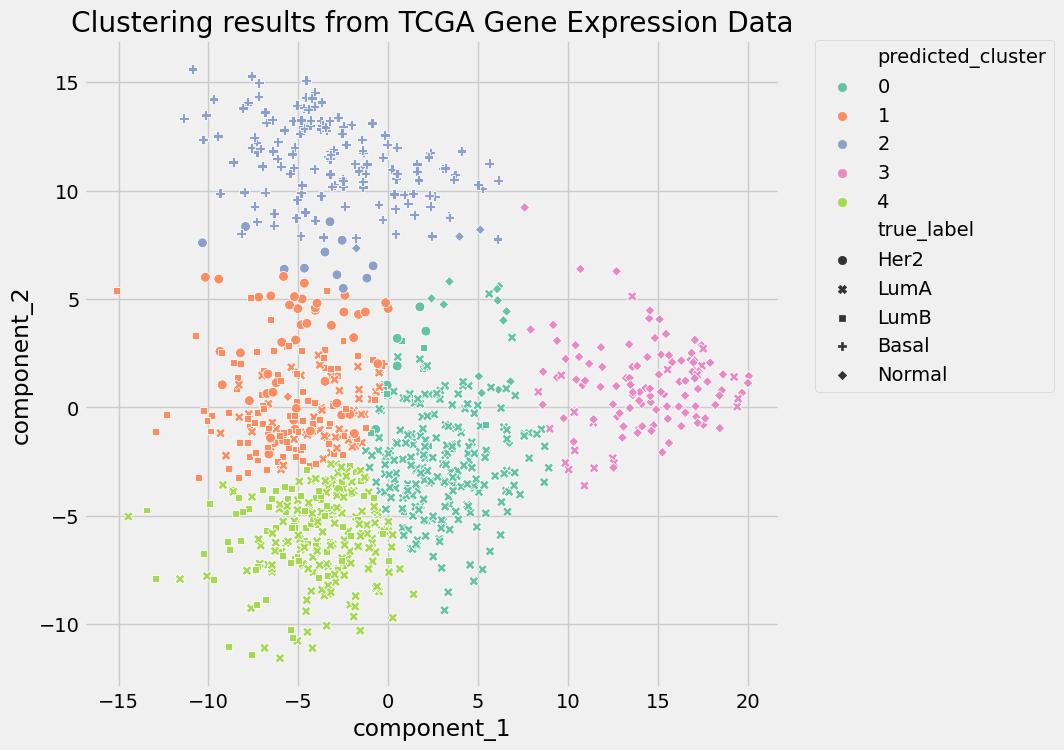

In [15]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
scat = sns.scatterplot(data=pcadf,x="component_1",y="component_2",s=50,hue="predicted_cluster",style="true_label",palette="Set2",)
scat.set_title("Clustering results from TCGA Gene Expression Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


In [22]:
# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 21):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(features)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(features),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

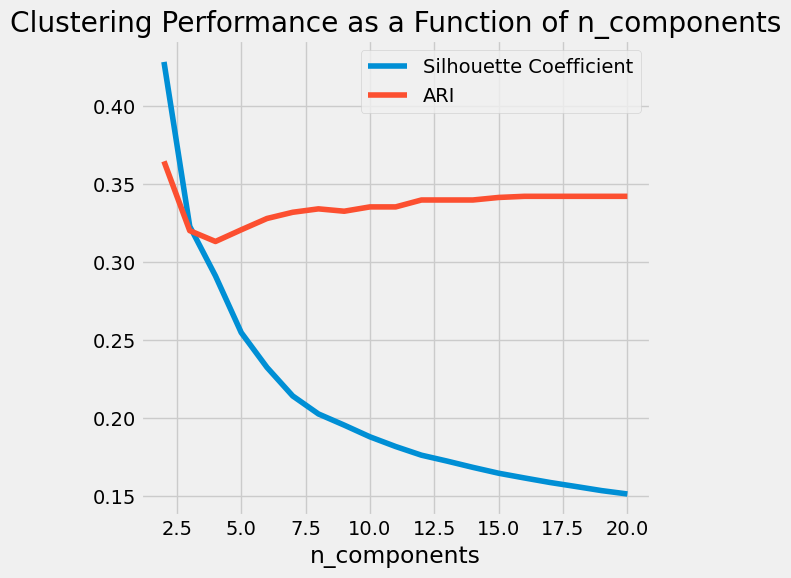

In [23]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 21),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 21), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()

https://realpython.com/k-means-clustering-python/